In [18]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np 
from monai.transforms import GaussianSmooth
import torch
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float

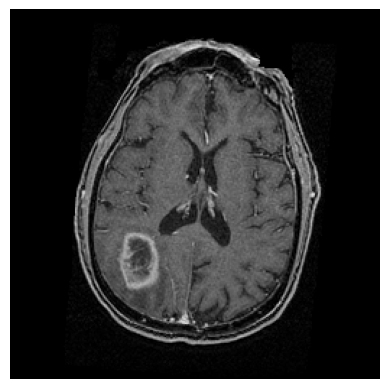

In [16]:
data = pydicom.dcmread("tciaDownload/1.3.6.1.4.1.14519.5.2.1.269607322454961545178354587485557855557/1-070.dcm")
img = data.pixel_array
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [20]:
def add_noise_to_dicom(img, noise_type='gaussian', noise_level=0.6):
    noisy_img = img.copy()
    
    if noise_type == 'gaussian':
        noise = np.random.normal(0, noise_level, img.shape)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, img.min(), img.max())
        
    elif noise_type == 'salt_pepper':
        salt_mask = np.random.random(img.shape) < (noise_level / 2)
        pepper_mask = np.random.random(img.shape) < (noise_level / 2)
        noisy_img[salt_mask] = img.max()
        noisy_img[pepper_mask] = img.min()
        
    elif noise_type == 'speckle':
        noise = np.random.normal(1, noise_level, img.shape)
        noisy_img = img * noise
        noisy_img = np.clip(noisy_img, img.min(), img.max())
    
    return noisy_img

In [21]:
def denoise_dicom_with_monai(img, sigma=5.0):
    img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).float()
    gaussian_smoother = GaussianSmooth(sigma=sigma)
    denoised_tensor = gaussian_smoother(img_tensor)
    return denoised_tensor.squeeze().cpu().numpy()

In [55]:
def denoise_dicom_with_skimage(img):
    img = img_as_float(img)
    sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
    
    denoised = denoise_nl_means(
        img,
        h=1.5 * sigma_est,            
        fast_mode=False,             
        patch_size=7,                 
        patch_distance=15,           
        channel_axis=None
    )
    return denoised

In [56]:
noisy_img = add_noise_to_dicom(img, noise_type='speckle', noise_level=0.3)

denoised_monai = denoise_dicom_with_monai(noisy_img, sigma=5.0)
denoised_skimage = denoise_dicom_with_skimage(noisy_img)

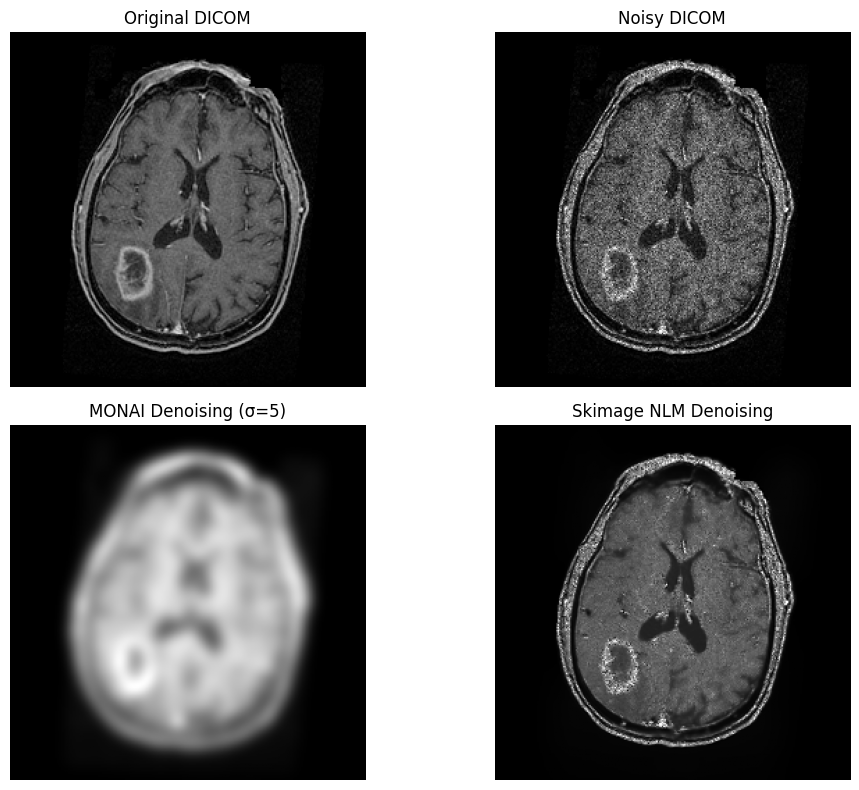

In [57]:
plt.figure(figsize=(15, 8))

plt.subplot(231)
plt.imshow(img, cmap='gray')
plt.title('Original DICOM')
plt.axis('off')

plt.subplot(232)
plt.imshow(noisy_img, cmap='gray')
plt.title('Noisy DICOM')
plt.axis('off')

plt.subplot(234)
plt.imshow(denoised_monai, cmap='gray')
plt.title('MONAI Denoising (σ=5)')
plt.axis('off')

plt.subplot(235)
plt.imshow(denoised_skimage, cmap='gray')
plt.title('Skimage NLM Denoising')
plt.axis('off')

plt.tight_layout()
plt.show()
